In [1]:
%matplotlib inline
import SimpleITK as sitk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import h5py
import matplotlib.pyplot as plt

In [2]:
cd ..

/home/chenxupeng/projects/pr


In [3]:
patient_info =pd.read_csv('data/annotations.csv')
id_ = np.loadtxt('label/idwithnodeindex',dtype = "S")
patient_info['node'] = id_
diameter = {}
for i in range(patient_info.shape[0]):
    diameter[i] = patient_info['diameter_mm'][i]

In [ ]:
patient_path = {}
coord_X = {}
coord_Y = {}
coord_Z = {}
diameter = {}
seriesuid = {}
for i in range(patient_info.shape[0]):
    patient_path[i] = 'data/train_set/'+ patient_info['seriesuid'][i] + '.mhd'
    coord_X[i]= patient_info['coordX'][i] 
    coord_Y[i]= patient_info['coordY'][i]
    coord_Z[i]= patient_info['coordZ'][i]
    diameter[i] = patient_info['diameter_mm'][i]
    seriesuid[i] = patient_info['seriesuid'][i]

In [ ]:
origin_node = {}
for i in range(patient_info.shape[0]):
    #找第i行node对应第几个病人的origin
    count = np.unique(np.array(patient_info["seriesuid"])[:i+1]).shape[0]
    origin_node[i] = origin[count-1]
v_center = {}
center = {}
for i in range(975):
    center[i] = np.array([coord_X[i],coord_Y[i],coord_Z[i]])
    v_center[i] = center[i] -origin_node[i] 
vcenter = np.array([val for (key,val) in v_center.iteritems()])

In [ ]:
index = np.array([])
for i in range(975):
    if vcenter[i][0] >0:
        if vcenter[i][1] >0:
            if vcenter[i][2] >0:
                index = np.concatenate((index,[i]))

In [20]:
for i in index:
    i = int(i)
    count = np.unique(np.array(patient_info["seriesuid"])[:i+1]).shape[0] -1 
    index_1, index_2 = count/20 +1 ,count%20
    with h5py.File('preprocess/processed_tensor/processed_tensor_'+str(index_1)) as f:
        t = f[f.keys()[int(index_2)]][:,:,:]
    local = vcenter[i]
    x,y,z = local[0],local[1],local[2]
    if 0 <= diameter[i] <= 6:
        r = 3      
    elif 6 <= diameter[i] < 16:
        r = 8
    else:
        r = 20
    ind = {}
    for j in range(12):
        tt= np.rint(np.array([x-r,x+r,y-r,y+r,z-r,z+r,z+2*r,z+3*r,x+2*r,x+3*r,y+2*r,y+3*r])).astype('int')
        ind[j+1] = tt[j] 
    tensor_posi = t[ind[1]:ind[2],ind[3]:ind[4],ind[5]:ind[6]]
    if round(z+3*r) < t.shape[2]:
        tensor_nega =  t[ind[1]:ind[2],ind[3]:ind[4],ind[7]:ind[8]]
    elif round(x+3*r) < t.shape[0]:
        tensor_negaa = t[ind[9]:ind[10],ind[3]:ind[4],ind[5]:ind[6]]
    elif round(y+3*r) < t.shape[1]:
        tensor_negaaa =  t[ind[1]:ind[2],ind[11]:ind[12],ind[5]:ind[6]]
    else:
        pass
    name = patient_info["node"][i]
    with h5py.File('preprocess/3D_/'+str(2*r)+'/'+name) as m:
        m.create_dataset('posi',data =tensor_posi )
        m.create_dataset('nega',data =tensor_nega )

In [9]:
'''
patient_path = {}
coord_X = {}
coord_Y = {}
coord_Z = {}
diameter = {}
seriesuid = {}
for i in range(patient_info.shape[0]):
    patient_path[i] = 'data/train_set/'+ patient_info['seriesuid'][i] + '.mhd'
    coord_X[i]= patient_info['coordX'][i] 
    coord_Y[i]= patient_info['coordY'][i]
    coord_Z[i]= patient_info['coordZ'][i]
    diameter[i] = patient_info['diameter_mm'][i]
    seriesuid[i] = patient_info['seriesuid'][i]

spacing = {}
img = {}
img_array = {}
for i in range(patient_info.shape[0]):
    img[i] = sitk.ReadImage(patient_path[i])
    spacing[i] = np.array(img[i].GetSpacing())
origin = {}
for i in range(patient_info.shape[0]):
    origin[i] = np.array(img[i].GetOrigin())
    
id_ = np.array(patient_info["seriesuid"])
idd = np.copy(id_)
for i in range(975):
    if id_[i] in idd[:i]:
        count = 1
        for j in range(i):
            if id_[i] == id_[j][:10]:
                count += 1
        id_[i] = id_[i]+'_'+str(count)
        print count
    else:
        id_[i] = id_[i]+'_'+str(1)
        
np.savetxt('label/idwithnodeindex',id_,fmt='%s')

#spacing dimension origin都是根据病人算的，要还原到975个样本里
with h5py.File('label/patientinfo') as f:
    for i in range(975):
        name = patient_info.iloc[i,5]
        f.create_group(name)
        f.create_dataset(name+'/coordX',data = coord_X[i])
        f.create_dataset(name+'/coordY',data = coord_Y[i])
        f.create_dataset(name+'/coordZ',data = coord_Z[i] )
        f.create_dataset(name+'/diameter',data = diameter[i])
        f.create_dataset(name+'/origin',data = origin[i])
        f.create_dataset(name+'/spacing',data = spacing[i])
distance_x= {}
distance_y= {}
distance_z= {}
diameter_x = {}
diameter_y = {}
diameter_z = {}
for i in range(975):
    diameter_x[i] = (origin[i][0] - coord_X[i])/spacing[i][0]
    diameter_y[i] = (origin[i][1] - coord_Y[i])/spacing[i][1]
    diameter_z[i] = (origin[i][2] - coord_Z[i])/spacing[i][2]
    distance_x[i] = diameter[i]/spacing[i][0]
    distance_y[i] = diameter[i]/spacing[i][1]
    distance_z[i] = diameter[i]/spacing[i][2]

with h5py.File('label/labelinfo') as f:
    for i in range(975):
        name = patient_info.iloc[i:i+1,0:1]
        f.create_group(name)
        f.create_dataset(name+'/diameter_x',data = diameter_x[i])
        f.create_dataset(name+'/diameter_y',data = diameter_y[i])
        f.create_dataset(name+'/diameter_z',data = diameter_z[i])
        f.create_dataset(name+'/distance_x',data = distance_x[i])
        f.create_dataset(name+'/distance_y',data = distance_y[i]) 
        f.create_dataset(name+'/distance_z',data = distance_z[i])
        f.create_dataset(name+'/dimension_x',data = )
        f.create_dataset(name+'/dimension_y',data = )
        f.create_dataset(name+'/dimension_z',data = )  

origin_ = {}
origin = np.array([[],[],[]]).T
for i in range(30):
    origin_[i] = np.loadtxt('preprocess/origin/origin_info_'+str(i+1)+'.txt',dtype = "S")
    origin = np.concatenate((origin,origin_[i]))
origin = origin.astype('float')
np.savetxt('preprocess/origin/origin.txt',origin,fmt = '%f')

#结节直径：diameter/spacing  处以2位半径  
#结节中心点： 算annotation的坐标距离样本中心坐标的dx dy dz，分别除以各自的spacing即为最后的距离  
#0-6   6-16   15-40  
#三个方向半径不同 按照最大长度 截正方体
#找到img的三个维度，中心点，由distance推算出要截的中心点  以及三个方向的最长长度   截出来正方体  
#即确定三个维度的i j k的范围  存下来这个范围  
#经过分析其实不需要spacing和origin的东西了，只用annotation，距离和diameter在新图像的上面是多少就是多少层！
origin = np.loadtxt('preprocess/origin/origin.txt')
#找到所有node对应的origin
origin_node = {}
for i in range(patient_info.shape[0]):
    #找第i行node对应第几个病人的origin
    count = np.unique(np.array(patient_info["seriesuid"])[:i+1]).shape[0]
    origin_node[i] = origin[count-1]
v_center = {}
center = {}
for i in range(975):
    center[i] = np.array([coord_X[i],coord_Y[i],coord_Z[i]])
    v_center[i] = origin_node[i] - center[i]
vcenter = np.array([val for (key,val) in v_center.iteritems()])
np.savetxt('preprocess/vcenter.txt',vcenter,fmt = '%f')

shapee = np.array([])
for i in range(975):
    count = np.unique(np.array(patient_info["seriesuid"])[:i+1]).shape[0] -1 
    index_1, index_2 = count/20 +1 ,count%20
    with h5py.File('preprocess/processed_tensor/processed_tensor_'+str(index_1)) as f:
        t = f[f.keys()[int(index_2)]][:,:,:]
        shape_ = np.array(t.shape)
    shapee = np.concatenate((shapee,shape_))
np.savetxt('preprocess/processedtensor_dimension.txt',shapee,fmt = '%f')
'''

In [17]:
#挑选三个文件夹下的posi和nega

In [73]:
cd /home/chenxupeng/projects/pr/preprocess/3D_/6

/home/chenxupeng/projects/pr/preprocess/3D_/6


In [69]:
name = np.loadtxt('a.txt',dtype = "S")
pick_posi = np.array([])
pick_nega = np.array([])
for i in range(name.shape[0]):
    with h5py.File(name[i]) as f:
        posi = f['posi'][:,:,:]
        nega = f['nega'][:,:,:]
    if posi.shape[0]+posi.shape[1]+posi.shape[2] ==48:
        pick_posi = np.concatenate((pick_posi,[name[i]]))
    if nega.shape[0]+nega.shape[1]+nega.shape[2] == 40:
        pick_nega = np.concatenate((pick_nega,[name[i]]))
np.savetxt('nega_pick',pick_nega,fmt = '%s')
np.savetxt('posi_pick',pick_posi,fmt = '%s')

In [70]:
pick_nega.shape

(197,)

In [71]:
name.shape

(373,)

In [72]:
pick_posi.shape

(189,)

In [74]:
name = np.loadtxt('a.txt',dtype = "S")
countposi = np.array([])
countnega = np.array([])
for i in range(name.shape[0]):
    with h5py.File(name[i]) as f:
        posi = f['posi'][:,:,:]
        nega = f['nega'][:,:,:]
    countposi = np.concatenate((countposi,[posi.shape[0]+posi.shape[1]+posi.shape[2]]))   
    countnega = np.concatenate((countnega,[nega.shape[0]+nega.shape[1]+nega.shape[2]]))  

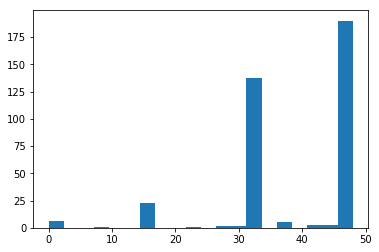

In [65]:
plt.hist(countposi,bins = 20)
plt.show()

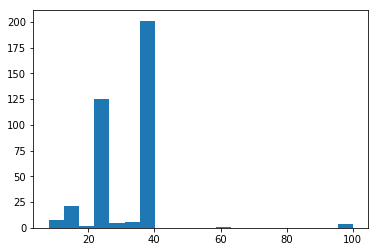

In [66]:
plt.hist(countnega,bins = 20)
plt.show()